## Project outline
### Could it have been predicted?

In this project we will develop a series of safety pharmacology models using python based cheminformatic tools such as Rdkit, Scikitlearn, and pytorch. We want to see if machine learning cheminformatic toxicity models can single out the molecules that were ultimately removed from the market. I have collected a database of drugs that were withdrawn from the market due to toxicity for various reasons. This can be combined with a database of currently available medications to form a test set which can be used to test a model designed to predict toxicity. Many of the drugs that have been withdrawn over the years were withdrawn due to hepatotoxicity or DILI (drug induced liver injury) so I have collected a dataset of molecules with BSEP binding values to develop a model capable of predicting hepatoxicity. This will be the first model. If time allows, we will also gather data on other toxicities responsible for drug withdrawal such as binding the HERG (IKr) associated protein and potentially other secondary pharmacology assay targets such as Gprotein-coupledreceptors (GPCRs), enzymes, kinases, nuclear hormone receptors, ion channels and transporters.

### References
Assay Targets:

Jenkinson, S., et al., A practical guide to secondary pharmacology in drug discovery. Journal of Pharmacological and Toxicological Methods, 2020. 105.

BSEP Database:

AbdulHameed, M.D.M., R. Liu, and A. Wallqvist, Using a Graph Convolutional Neural Network Model to Identify Bile Salt Export Pump Inhibitors. ACS Omega, 2023. 8(24): p. 21853-21861.

Dataset of Withdrawn drugs:

Siramshetty, V.B., et al., WITHDRAWN--a resource for withdrawn and discontinued drugs. Nucleic Acids Res, 2016. 44(D1): p. D1080-6.

Onakpoya, I. J., Heneghan, C. J., & Aronson, J. K. (2016). Post-marketing withdrawal of 462 medicinal products because of adverse drug reactions: a systematic review of the world literature. BMC Medicine, 14, 10.

## Import Dependencies

In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
#---------------------- Therapeutic Drug Commons (TDC data) from https://tdcommons.ai/single_pred_tasks/tox/#dili-drug-induced-liver-injury
from tdc.single_pred import Tox
#---------------------- RDKit packages
from rdkit.Chem import AllChem
#-
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import ensemble
from sklearn.model_selection import ShuffleSplit, cross_validate, train_test_split
from sklearn.model_selection import RandomizedSearchCV

## Data cleaning

### Reading, converting to pandas

Read TDC Tox DILI Dataset & convert to Pandas dataframe.\
Rename columns to be more human-readable.

In [ ]:
# This is Xu dataset
tox_data = Tox(name = 'DILI')
xu_df = tox_data.get_data()

xu_df = (xu_df
        .drop('Drug_ID', axis=1)
        .rename(columns={'Drug' : 'SMILES', 'Y' : 'DILI?'})
        .astype({'DILI?' : 'Int16'})
)

xu_df.to_csv('Transformed_Data/Xu_DILI.csv')

In [ ]:
import pubchempy as pcp

onakpoya_df = pd.read_csv('Transformed_Data/Onakpoya_Drugs.csv', skiprows=[0]) # Read the table as csv

onakpoya_df = (onakpoya_df
    .filter(['Medicinal product', 'Reason for withdrawal']) # Drop irrelevant columns
    .replace({'‡':''}, regex=True) # Remove uninterpretable characters
)

onakpoya_df = onakpoya_df[onakpoya_df['Reason for withdrawal'].str.endswith('Liver', na = False)] # Drop non-DILI related withdrawal
onakpoya_df['Medicinal product'] = onakpoya_df['Medicinal product'].str.partition(' ')[0] # Only keep first word of drug name

onakpoya_df['pcp_result'] = onakpoya_df['Medicinal product'].map(lambda x: pcp.get_compounds(identifier=x, namespace='name')) # Get pubchem CID for each compound
onakpoya_df = onakpoya_df[onakpoya_df['pcp_result'].map(lambda d: len(d)) == 1] # Drop columns with multiple chemical identifiers

onakpoya_df['pcp_result'] = onakpoya_df['pcp_result'].str[0] # Convert list of pubchempy compounds to str
onakpoya_df['pcp_result'] = onakpoya_df['pcp_result'].apply(lambda x: x.isomeric_smiles) # Get isomeric smiles for pubchempy compounds

onakpoya_df.columns = ['Drug', 'DILI?', 'SMILES']

onakpoya_df = (onakpoya_df
    .filter(['DILI?', 'SMILES']) # Drop drug name
    .reindex(columns = ['SMILES', 'DILI?']) # Reorder columns
    .replace({'Liver' : 1}) # Liver = 1
)

onakpoya_df.to_csv('Transformed_Data/Onakpoya_DILI.csv')

Concatenate the data from different sources

In [ ]:
tox_df = pd.concat([xu_df, onakpoya_df])

tox_df.to_csv('Transformed_Data/Final_DILI.csv')

In [ ]:
Hameed_df = pd.read_excel('Transformed_Data/Hameed_BSEP.xlsx', sheet_name=1, usecols = range(1, 3))

print(Hameed_df.info(2))

# Get Fingerprints

Define function 'generate_fingerprints'
Initialise empty list of Morgan fingerprints
for molecules in a given dataframe, generate their morgan fingerprints and append them to the dataframe
Reutrn appended dataframe as numpy array to analyse using 'shape'

Run generate_fingerprints on each molecule in the dataframe

Use shape to confirm success - First number should equal dataframe length


In [5]:
tox_df = pd.read_csv('Transformed_Data/Final_DILI.csv')

In [6]:
from rdkit.Chem import MolFromSmiles

def smiles_to_morgan_fingerprint(smiles):
    mol = MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits = 2048)
    return fingerprint

tox_df['M3FP'] = [smiles_to_morgan_fingerprint(smiles) for smiles in tox_df['SMILES']]

print(tox_df.info(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  507 non-null    int64 
 1   SMILES      507 non-null    object
 2   DILI?       507 non-null    int64 
 3   M3FP        507 non-null    object
dtypes: int64(2), object(2)
memory usage: 16.0+ KB
None


In [15]:
morgan_df = pd.DataFrame(tox_df['M3FP'])

morgan_df.insert(len(morgan_df.columns), 'DILI?', tox_df['DILI?'].astype(int)) # Insert 'DILI?' column as the last column

morgan_df.columns = morgan_df.columns.astype(str) # Set all column titles to string - Required for model

print(morgan_df.info(2))

#X = np.array(morgan_df['M3FP'])
X = morgan_df['M3FP'] # Features
y = morgan_df['DILI?'] # Labels

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   M3FP    507 non-null    object
 1   DILI?   507 non-null    int32 
dtypes: int32(1), object(1)
memory usage: 6.1+ KB
None


In [19]:
# Set up scoring methods for hyperparameter tuning
scoring = ['r2', 'neg_root_mean_squared_error']

# Enable multithreading functionality
import multiprocessing
n_jobs = multiprocessing.cpu_count()-1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75)

In [31]:
# Instantiate Random Forest Regressor
model_rf = ensemble.RandomForestClassifier(random_state=42)

# Instantiate a dict of paramaters of RFR
params_rf = {
            'bootstrap': [True, False],
            'max_depth': [range(1, 4096, 1000), None],
            'max_features': ['auto', 'sqrt', 'log2', 1],
            'min_samples_leaf': range(1, 8, 1),
            'min_samples_split': range(1, 8, 1),
            'n_estimators': range(10, 800, 10)
            }

In [32]:
# Run RandomizedSearchCV to optimise random forest hyperparameters
rf_cv = RandomizedSearchCV(model_rf, params_rf, cv = 5, n_iter=64, n_jobs=n_jobs, random_state=42, scoring='r2') #5-fold precedended in AbdulHameed

rf_cv.fit(list(X_train),y_train)

#rf_cv.score(list(X_test), y_test)

# Print scores
print('Tuned Logistic Regression Parameters: {}'.format(rf_cv.best_params_)) 
print('Best score is {}'.format(rf_cv.best_score_))

Tuned Logistic Regression Parameters: {'n_estimators': 710, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Best score is 0.30425502425502426


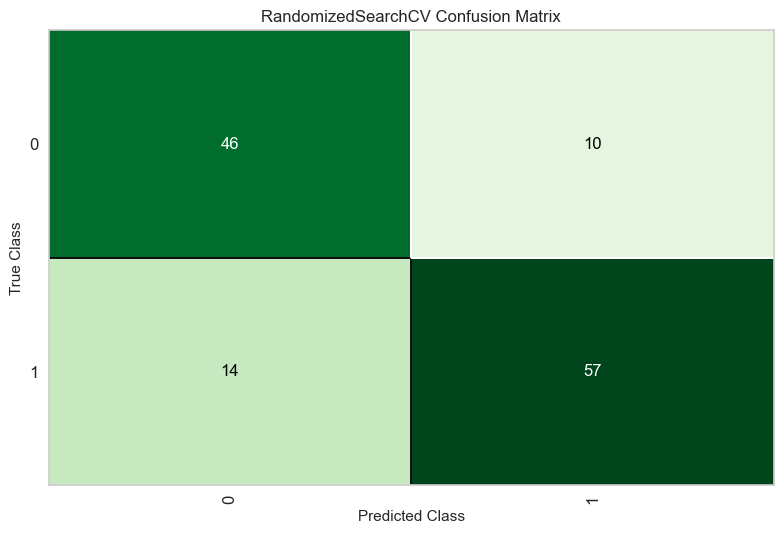

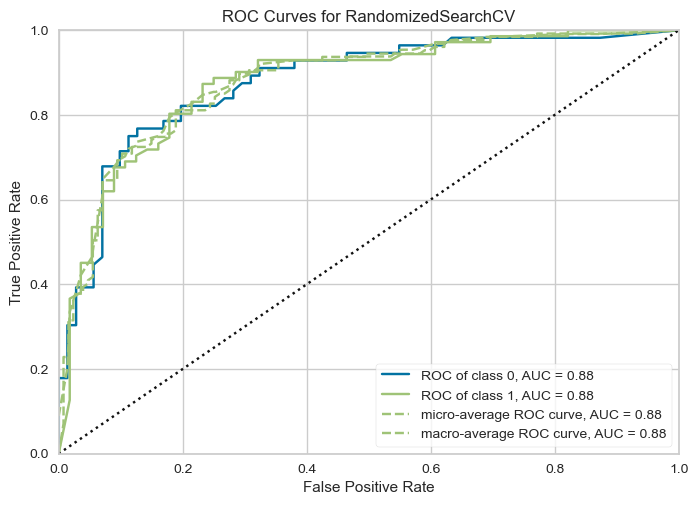

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for RandomizedSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=RandomizedSearchCV(cv=5,
                                    estimator=RandomForestClassifier(random_state=42),
                                    n_iter=64, n_jobs=11,
                                    param_distributions={'bootstrap': [True,
                                                                       False],
                                                         'max_depth': [range(1, 4096, 1000),
                                                                       None],
                                                         'max_features': ['auto',
                                                                          'sqrt',
                                                                          'log2',
                                                                          1],
                                                         'min_samples_leaf': range(1, 8),
                                                         'min_samples_split': range(1, 8),
                                                         'n_estimators': range(10, 800, 10)},
                                    random_state=42, scoring='r2'))

In [38]:
from yellowbrick import classifier

classifier.confusion_matrix(rf_cv, list(X_test), y_test, cmap="Greens")

classifier.roc_auc(rf_cv, list(X_test), y_test)

In [ ]:
from tpot import TPOTRegressor

pipeline_optimiser = TPOTRegressor(random_state = 42, n_jobs=n_jobs)

pipeline_optimiser.fit(X_train, y_train)
print(pipeline_optimiser.score(X_test, y_test))

In [46]:
# Instantiate an XGBoost

model_gb = ensemble.GradientBoostingClassifier(random_state=42)

params_gb = {
            'max_depth': [2, 3, 5, 10, 15],
            'learning_rate': [0.05, 0.1, 0.15, 0.20]
            }

from sklearn.model_selection import RandomizedSearchCV

gb_cv = RandomizedSearchCV(model_gb, params_gb, cv = 5, n_iter=32, n_jobs=n_jobs, random_state=42, scoring='r2')

gb_cv.fit(list(X_test), y_test)

# Print scores
print('Tuned Logistic Regression Parameters: {}'.format(gb_cv.best_params_)) 
print('Best score is {}'.format(gb_cv.best_score_))

Tuned Logistic Regression Parameters: {'max_depth': 3, 'learning_rate': 0.1}
Best score is -0.14909090909090922


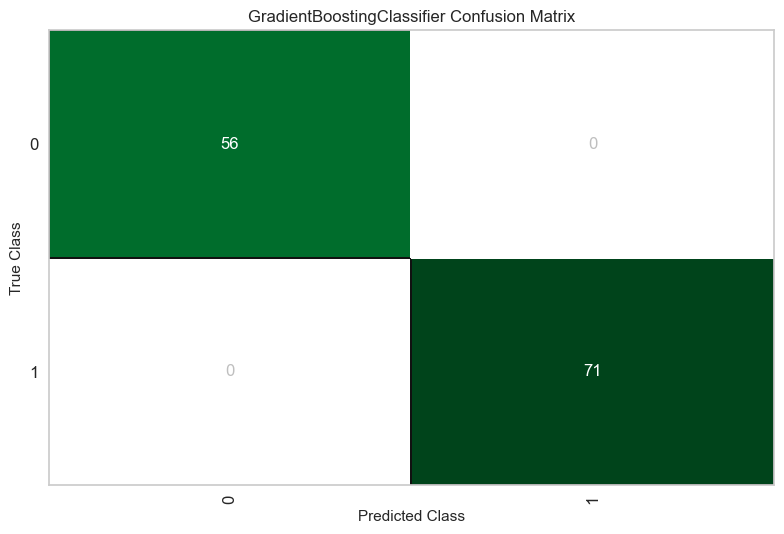

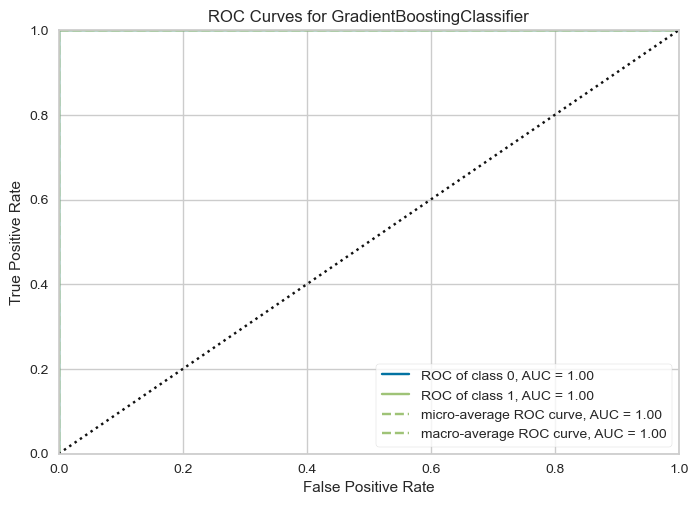

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for GradientBoostingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=GradientBoostingClassifier(random_state=42))

In [44]:
classifier.confusion_matrix(gb_cv, list(X_test), y_test, cmap="Greens")

classifier.roc_auc(gb_cv, list(X_test), y_test)

## Thanks To

https://www.youtube.com/watch?v=-oHqQBUyrQ0

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

https://github.com/PatWalters/practical_cheminformatics_posts/blob/main/solubility/literature_solubility_model.ipynb

https://leftwinglow.github.io/BachelorsProject/

https://github.com/gashawmg/Molecular-fingerprints/blob/main/Calculating%20molecular%20fingerprints%20available%20in%20RDkit%20.ipynb

https://github.com/gashawmg/Avalon-fingerprints-for-machine-learning/blob/main/Avalon%20fingerprints%20for%20predictive%20modeling.ipynb